In [1]:
%matplotlib inline

import gc
import os
import sys
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from scipy.stats import mode
import pickle
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

import textract
import docx2txt
import PyPDF2
from PyPDF2 import PdfFileReader
import glob

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn import preprocessing
import joblib
from striprtf.striprtf import rtf_to_text

from lightgbm import LGBMClassifier, LGBMRegressor, log_evaluation
from lightgbm import early_stopping
from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from transformers import AutoTokenizer, AutoModel

from IPython.display import clear_output

target = 'label'
path = '../input/dataset/'

clear_output(wait = False)

In [2]:
#len_txt = [100:2000]
dtrain = pd.DataFrame(columns = ['text', 'label'])

path = '../input/dataset/'

paths = os.listdir(path)
paths.remove('readme.md')
paths.remove('sample.csv')
paths = sorted(paths)
paths

['act',
 'application',
 'arrangement',
 'bill',
 'contract',
 'contract_offer',
 'determination',
 'invoice',
 'order',
 'proxy',
 'statute']

In [3]:
for label in paths:
    doc_list = glob.glob(path + label + '/*.rtf')
    for path_doc in doc_list:
        L = dtrain.shape[0]    
        dtrain.loc[L, 'label'] = label
        try:
            with open(path_doc) as infile:
                content = infile.read()
                text = rtf_to_text(content)
            dtrain.loc[L, 'text'] = text[100:2000]
        except:
            print('error in :', path_doc)
            pass

        
dtrain = dtrain[dtrain['text'] == dtrain['text']]    
dtrain = dtrain[dtrain['text'] != '']
dtrain = dtrain[dtrain['text'] != ' '] 
dtrain.to_csv('dtrain.csv', index = False)   
dtrain.sample(10)

error in : ../input/dataset/act/document_act.rtf
error in : ../input/dataset/act/Akt.rtf
error in : ../input/dataset/bill/apellyatsionnaya_galoba_na_reshenie_suda_pervoy_instantsii_po_gragdanskim_delam.rtf
error in : ../input/dataset/contract_offer/puboferta.rtf
error in : ../input/dataset/determination/rechenie verchovnogo suda.rtf


,text,label
530,ВОЙ ПОМОЩИ И ПРАВОВЫХ ОТНОШЕНИЯХ ПО ГРАЖДАНСКИ...,contract
856,НИЙ\n\nВ ЕДИНЫЙ ГОСУДАРСТВЕННЫЙ РЕЕСТР ОБЪЕКТО...,order
920,МУ РЕГУЛИРОВАНИЮ\n\nИ МЕТРОЛОГИИ\n\n\nПРИКАЗ\n...,order
617,О ВЗАИМНОЙ ПРАВОВОЙ ПОМОЩИ ПО УГОЛОВНЫМ ДЕЛАМ...,contract
454,"-8"" /><meta name=""description"" content=""Защита...",arrangement
443,"-8"" /><meta name=""description"" content=""Защита...",arrangement
281,"-8"" /><meta name=""description"" content=""Защита...",arrangement
792,МУ РЕГУЛИРОВАНИЮ\n\nИ МЕТРОЛОГИИ\n\n\nПРИКАЗ\n...,order
504,"-8"" /><meta name=""description"" content=""Защита...",arrangement
824,В СФЕРЕ ПРИРОДОПОЛЬЗОВАНИЯ\n\n\nПРИКАЗ\n\nот 6...,order


In [4]:
use = ['text']
temp = dtrain.drop_duplicates(subset = use)
dublicates = dtrain[use][~dtrain.index.isin(temp.index)]
print(len(dublicates))

504


In [5]:
dublicates

,text
20,"-8"" /><meta name=""description"" content=""Защита..."
21,"-8"" /><meta name=""description"" content=""Защита..."
22,"-8"" /><meta name=""description"" content=""Защита..."
23,"-8"" /><meta name=""description"" content=""Защита..."
24,"-8"" /><meta name=""description"" content=""Защита..."
...,...
643,"ru (далее ПРОДАВЕЦ), публикует настоящий догов..."
654,"публикует настоящий договор, являющийся публич..."
660,ня 2011 года \nПервомайский районный суд г. Ки...
675,"""Ростелеком""|||||\n|||||||\nАдрес||191167, Г...."


In [6]:
dtrain[target].value_counts().sort_index()

label
act                 8
application         9
arrangement       505
bill                4
contract          108
contract_offer     17
determination      13
invoice            10
order             260
proxy               7
statute            10
Name: count, dtype: int64

/home/vlad/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='label', ylabel='Count'>

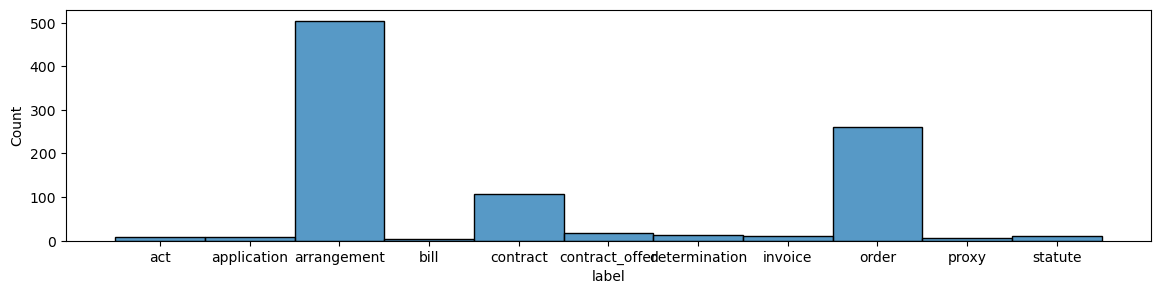

In [7]:
plt.figure(figsize = (14, 3))
sns.histplot(dtrain[target])

In [8]:
import re
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer

morph = MorphAnalyzer()
stop_words = stopwords.words('russian')
stop_words.append('г')
#stop_words.append('год')
#stop_words.append('гр')
#stop_words.append('рф')

def clear_text(text):
    
    text = " ".join((re.sub(r'[^-а-яА-ЯёЁ]', ' ', text).split())).lower()    
    
    out = []
    for token in text.split():
        token = morph.normal_forms(token)[0]
        out.append(token)
    
    text = " ".join(out)
    text = " ".join([word for word in text.split() if word not in stop_words])
    
    return text

dtrain['text'] = dtrain['text'].apply(lambda x: clear_text(str(x)))

In [9]:
dtrain['text'].sample(10)

78     - защита документ крупный сеть база судебный а...
630    обложение предотвращение уклонение налогооблож...
483    - защита документ крупный сеть база судебный а...
937    нения положение департамент финансы министерст...
47     - защита документ крупный сеть база судебный а...
945    полный наименование организация индивидуальный...
817    му регулирование метрология приказ март -ст ут...
5      ия работа технический обслуживание средство об...
567    ной народный республика югославия правовой пом...
774    б исключение сведение туроператор единый федер...
Name: text, dtype: object

In [10]:
use = ['text']
temp = dtrain.drop_duplicates(subset = use)
dublicates = dtrain[use][~dtrain.index.isin(temp.index)]
print(len(dublicates))

507


In [11]:
dublicates

,text
20,- защита документ крупный сеть база судебный а...
21,- защита документ крупный сеть база судебный а...
22,- защита документ крупный сеть база судебный а...
23,- защита документ крупный сеть база судебный а...
24,- защита документ крупный сеть база судебный а...
...,...
672,ростелеком адрес санкт-петербург вн тереть мун...
675,ростелеком адрес санкт-петербург вн тереть мун...
678,ростелеком адрес санкт-петербург вн тереть мун...
749,сфера природопользование приказ март исключени...


In [12]:
dtrain = dtrain.drop_duplicates(subset = use, keep = 'first')
dtrain[target].value_counts().sort_index()

label
act                 8
application         9
arrangement         6
bill                4
contract          108
contract_offer     15
determination      12
invoice             7
order             258
proxy               7
statute            10
Name: count, dtype: int64

In [13]:
le = preprocessing.LabelEncoder()
dtrain[target] = le.fit_transform(dtrain[target])

joblib.dump(le, 'le.pkl')

['le.pkl']

In [14]:
dtrain[target].value_counts().sort_index()

label
0       8
1       9
2       6
3       4
4     108
5      15
6      12
7       7
8     258
9       7
10     10
Name: count, dtype: int64

In [15]:
from sklearn.utils.class_weight import compute_class_weight

values = compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(dtrain[target]), 
    y = dtrain[target]
)
keys = list(np.unique(dtrain[target]))

class_weight = dict(zip(keys, values))
#class_weight = torch.tensor(values, dtype = torch.float32)
class_weight

{0: 5.045454545454546,
 1: 4.484848484848484,
 2: 6.7272727272727275,
 3: 10.090909090909092,
 4: 0.37373737373737376,
 5: 2.690909090909091,
 6: 3.3636363636363638,
 7: 5.766233766233766,
 8: 0.15644820295983086,
 9: 5.766233766233766,
 10: 4.036363636363636}

In [16]:
dtrain.shape

(444, 2)

In [17]:

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

In [18]:
import torch

def embed(data, cls = True, length = 256, test = False):
    
    col = list(data.columns).index('text')
    
    emb = np.zeros([1, 312])
    batch_size = 2

    for index in range(0, len(data), batch_size):

        batch = list(data.iloc[index: min(index + batch_size, data.shape[0]), col])
        
        encoded_input = tokenizer(
            batch, 
            padding = True, 
            truncation = True, 
            return_tensors = 'pt', 
            max_length = length
        )

        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in encoded_input.items()})
        if cls:
            embeddings = model_output.last_hidden_state[:, 0, :]
        else:
            embeddings = model_output.pooler_output
            
        embeddings = torch.nn.functional.normalize(embeddings)
        emb = np.vstack((emb, embeddings))

    return emb[1:]

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    dtrain, dtrain[target], 
    test_size = 0.1, 
    random_state = 0, 
    stratify = dtrain[target]
)

In [20]:
%%time
X_train = pd.DataFrame(embed(X_train, test = False, cls = False))
use = ['emb_' + str(f) for f in range(X_train.shape[1])]
X_train.columns = use
print(X_train.shape)

(399, 312)
CPU times: user 57.4 s, sys: 256 ms, total: 57.7 s
Wall time: 4.46 s


In [21]:
%%time
X_val = pd.DataFrame(embed(X_val, test = False, cls = False))
X_val.columns = use
print(X_val.shape)

(45, 312)
CPU times: user 7.45 s, sys: 12.2 ms, total: 7.46 s
Wall time: 573 ms


In [22]:
model = LogisticRegression(C = 1, class_weight = class_weight)
model.fit(X_train, y_train)

LogisticRegression(C=1,
                   class_weight={0: 5.045454545454546, 1: 4.484848484848484,
                                 2: 6.7272727272727275, 3: 10.090909090909092,
                                 4: 0.37373737373737376, 5: 2.690909090909091,
                                 6: 3.3636363636363638, 7: 5.766233766233766,
                                 8: 0.15644820295983086, 9: 5.766233766233766,
                                 10: 4.036363636363636})

In [23]:
y_pred = model.predict(X_val)
f1_score(y_val, y_pred, average = 'weighted')

0.85679012345679

In [24]:
import umap  # pip install umap-learn

manifold = umap.UMAP().fit(X_train, y_train)
X_trn_reduced = manifold.transform(X_train)
X_val_reduced = manifold.transform(X_val)

clear_output(wait = False)

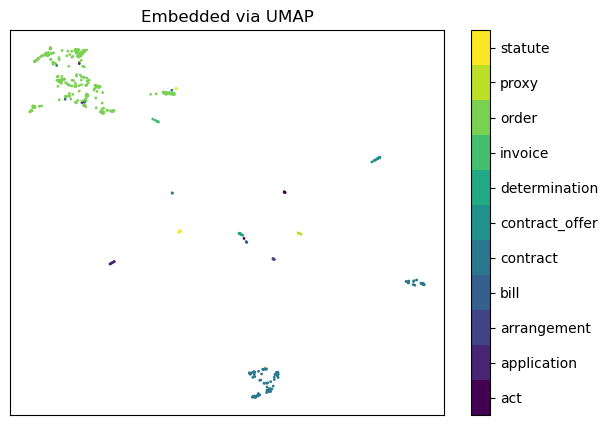

In [25]:
le = joblib.load('le.pkl')

fig, ax = plt.subplots(1, figsize=(7, 5))
classes = list(le.classes_)

plt.scatter(X_trn_reduced[:, 0], X_trn_reduced[:, 1], c = y_train, s = 1);
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(len(le.classes_) + 1) - 0.5)
cbar.set_ticks(np.arange(len(le.classes_)))
cbar.set_ticklabels(classes)
plt.title('Embedded via UMAP');